CPS-based estimate of employment-population ratio
=====

## EPOPs for Various Groups by Gender, Age, Education

-----

*September 6, 2017*<br>
*Brian Dew, dew@cepr.net*

This notebook aims to calculate the employment to population ratio for each year since 1980 for each group by gender, age (16-24, 25-34, 35-44, 45-54, 55-64, and 65+), and education (less than high school, high school diploma, some college, college, advanced degress).

The source data is the [CEPR uniform data extracts based on the CPS Outgoing Rotation Group (ORG)](http://ceprdata.org/cps-uniform-data-extracts/cps-outgoing-rotation-group/). 

Separately, 2017 figures (preliminary) through July are obtained from the CPS FTP pages. The education variable is adjusted to match with the CEPR extracts as shown in [this file](C:/Working/Python/CPS/CPS_Monthly.ipynb).

See EPOPS_example.ipynb as a proof of concept that the basic strategy for summarizing the microdata from the CPS will match with the BLS summary statistics.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rc('axes', edgecolor='white')
plt.rc('axes', axisbelow=True)

%matplotlib inline

In [2]:
# Which columns to keep
cols = ['year', 'female', 'age', 'educ', 'empl', 'orgwgt']

# Male = 0, Female = 1
gender = {'Male': 0, 'Female': 1}

# Expand years once full data is in place
date_range = (1979, 2017)
sdate = date_range[0]
ldate = date_range[1]-1
ldatep = date_range[1]
years = range(sdate, ldatep+1)

# Age groups (110 used just as max value)
ages = [(16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 110), (16, 110), (25, 54)]

# Education level
educs = [['LTHS'], ['HS'], ['Some college'], ['College'], ['Advanced'], ['LTHS', 'HS'], ['College', 'Advanced']]

#### Looping through CEPR CPS ORG datasets and storing results

Filter by criteria listed above to identify the weighted total and employed populations for each group. Next calculate ratio of employed to population.

In [3]:
data = pd.DataFrame()
first = pd.DataFrame()
last = pd.DataFrame()
lastp = pd.DataFrame()
for y in years:
    yr = pd.to_datetime('{}-01-01'.format(y))
    filename = 'C:/Working/EPOPs/data/cepr_org_{}.dta'.format(y)
    df = pd.read_stata(filename, columns=cols)
    tot_pop = df['orgwgt'].sum()
    for g, gn in gender.items():
        for start, end in ages:
            a = '{}-{}'.format(start, end)
            if end == 110:
                a = '{}+'.format(start)
            for e in educs:
                # The next lines filter by age, gender, and
                # education, calculate the employed and total
                # for each group, and the ratio of employed
                # to group population
                dft = df[(df['age'] >= start) & 
                        (df['age'] <= end) &
                        (df['female'] == gn) & 
                        (df['educ'].isin(e))]
                pop = dft['orgwgt'].astype(float).sum()
                epop = (dft['orgwgt'] * dft['empl']).sum() / pop
                epop = str(round(epop * 100, 1))
                # Generate group description column name
                ed = e[0]
                if len(e) > 1:
                    ed = '{} or {}'.format(e[0], e[1])
                cname = '{}: {}: {}'.format(g, a, ed)
                data.set_value(yr, cname, epop)

                # Collect additional information on the first and 
                # last observations
                if y in [years[0]]:
                    first.set_value(y, cname, int(round(pop)))
                    Nfirst = tot_pop
                if y in [years[-1]]:
                    lastp.set_value(y, cname, int(round(pop)))
                    Nlastp = tot_pop
                if y in [years[-2]]:
                    last.set_value(y, cname, int(round(pop)))
                    Nlast = tot_pop

In [4]:
data.to_csv('results/epops_clean.csv')

#### Summarizing the results over key periods

Compute the period averages and percent change for:

* 1979-1988
* 1989-1999
* 2000-2013
* 2014-2017(p)

In [5]:
sdata = pd.read_csv('results/epops_clean.csv').set_index('Unnamed: 0')
summary_table = pd.DataFrame()

sdates = [('1979-01-01', '1988-01-01'), 
          ('1988-01-01', '2000-01-01'), 
          ('2000-01-01', '2015-01-01'), 
          ('2015-01-01', '2017-01-01'),
          ('1979-01-01', '2017-01-01')]

for name, values in sdata.iteritems():
    for date_range in sdates:
        dr_mean_name = date_range[0][:4] + '-' + date_range[1][:4] + ' Mean'
        dr_ch_name = date_range[0][:4] + '-' + date_range[1][:4] + ' Change'
        period_mean = values.loc[date_range[0]:date_range[1]].mean()
        period_change = values.loc[date_range[1]] - values.loc[date_range[0]]
        summary_table.set_value(name, dr_mean_name, period_mean)
        summary_table.set_value(name, dr_ch_name, period_change)

In [6]:
summary_table.round(2).to_csv('results/EPOPs_summary_table.csv')

#### Plotting the results

Generate a small plot of each EPOP rate

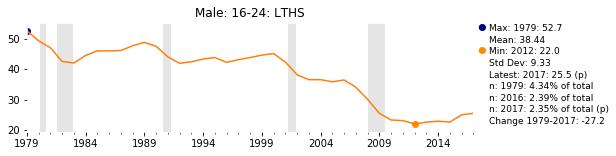

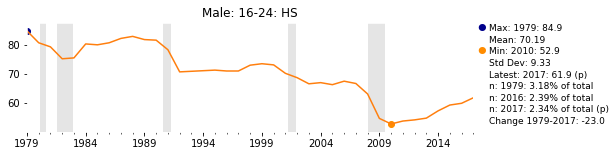

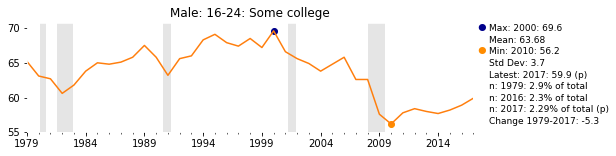

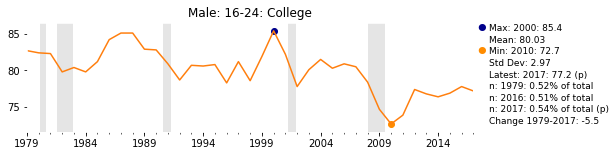

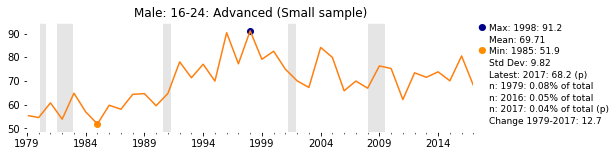

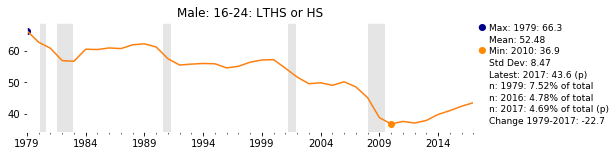

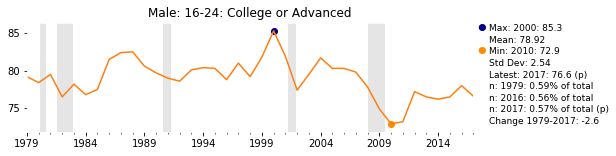

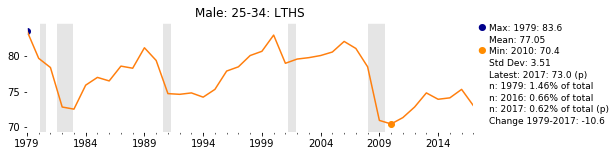

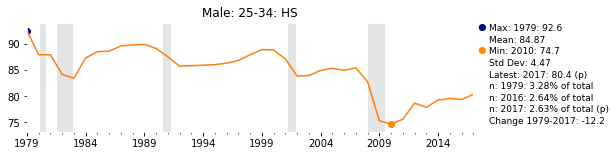

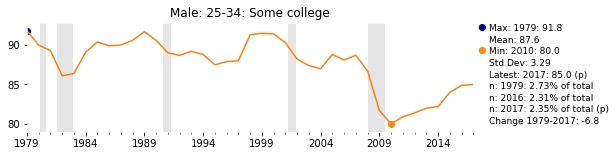

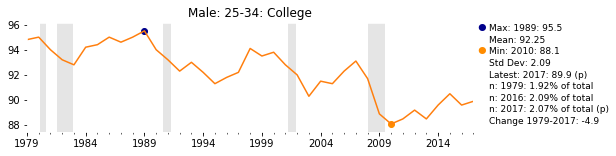

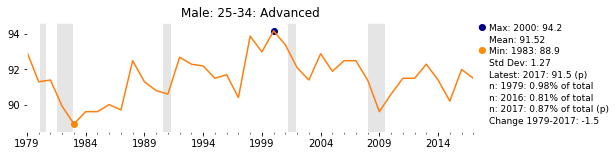

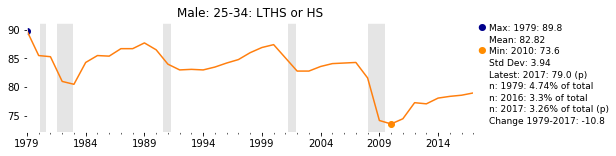

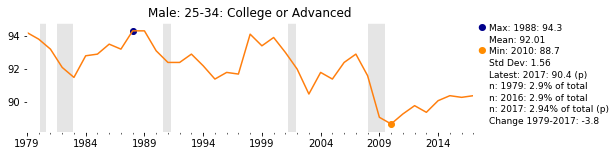

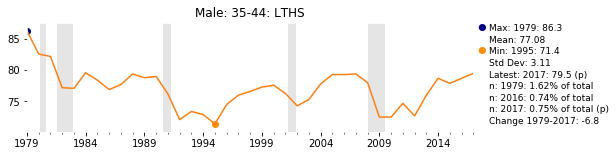

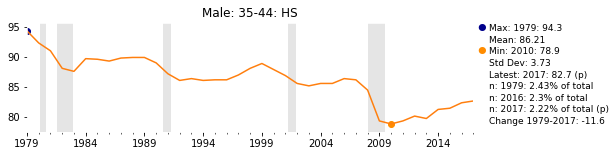

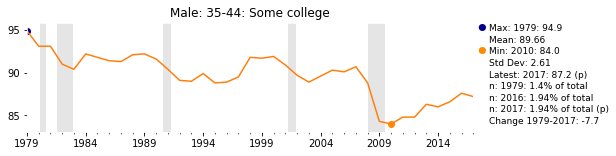

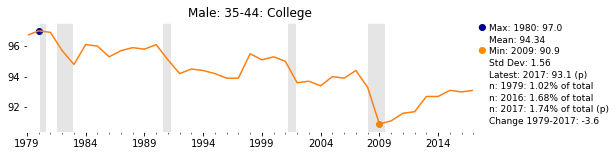

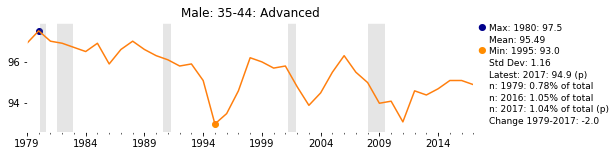

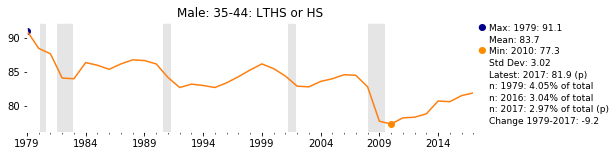

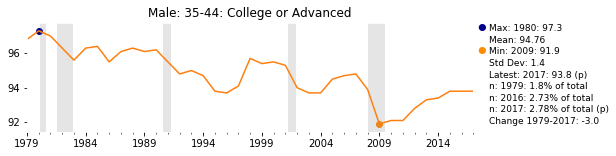

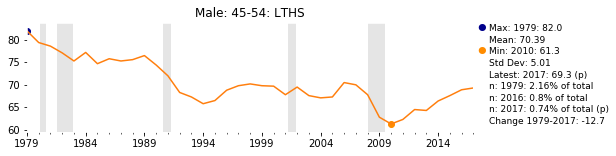

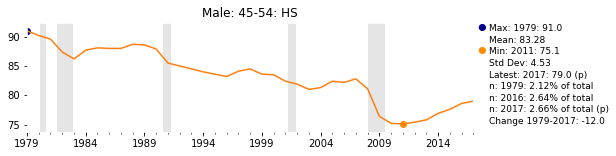

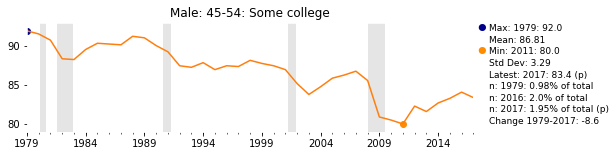

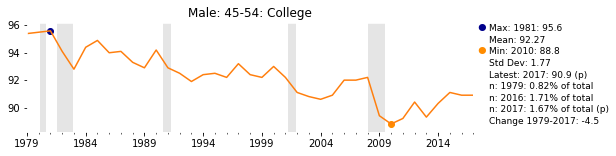

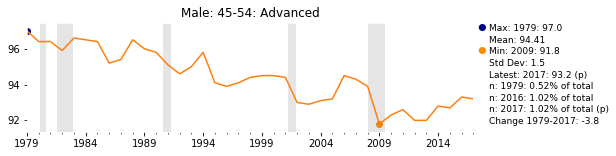

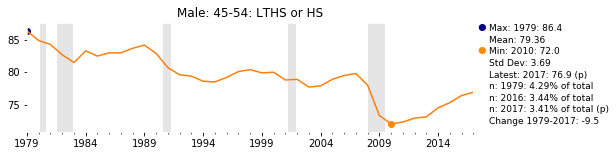

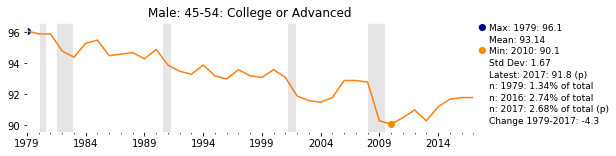

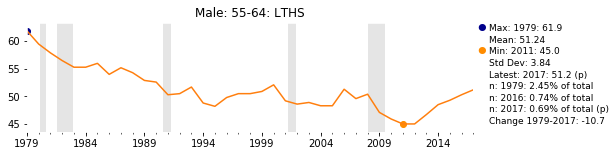

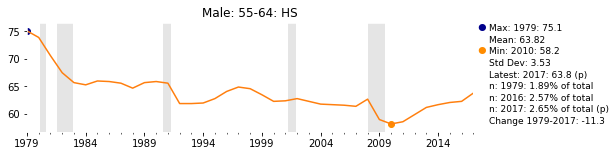

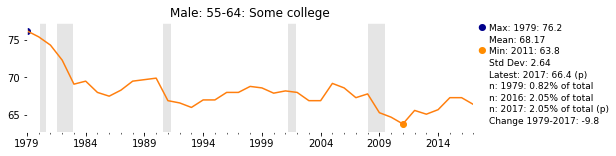

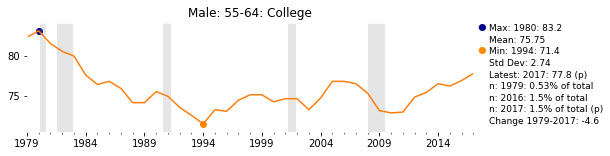

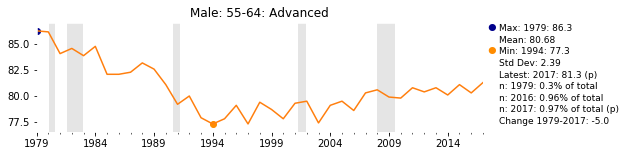

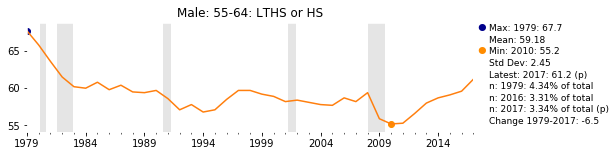

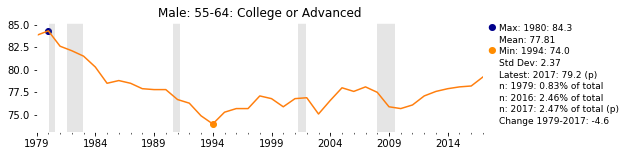

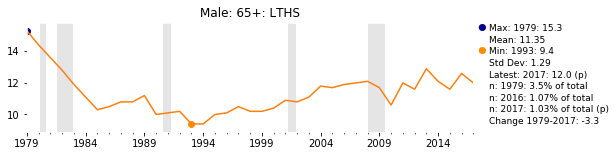

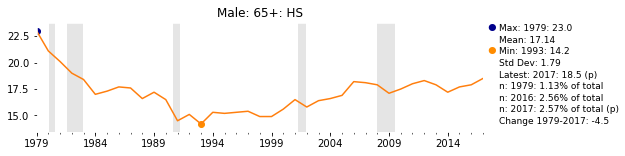

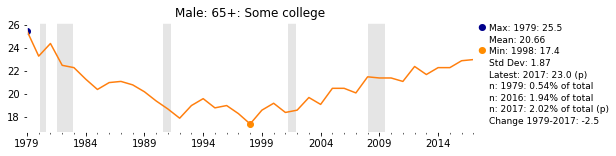

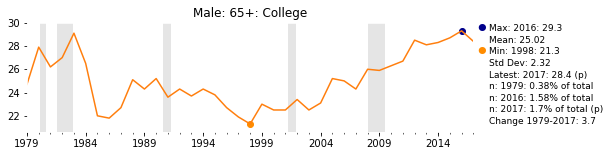

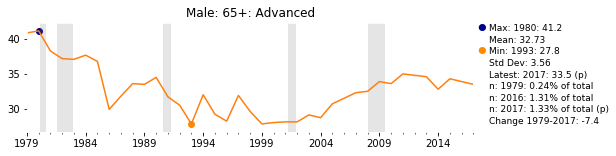

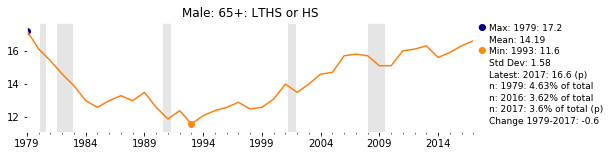

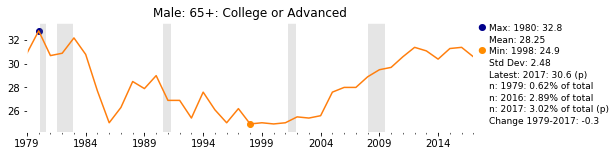

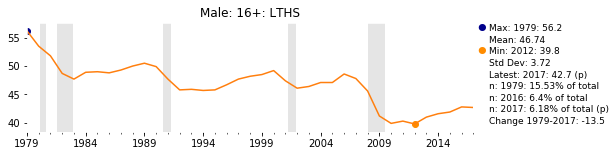

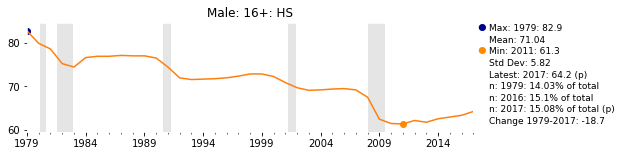

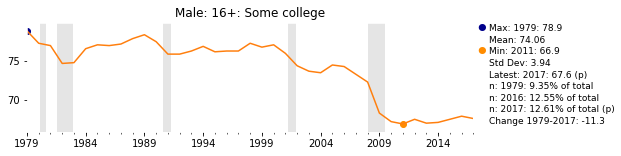

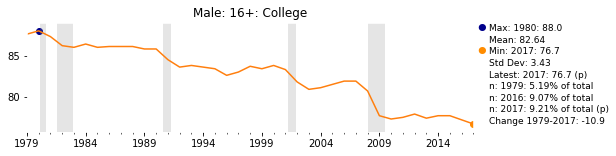

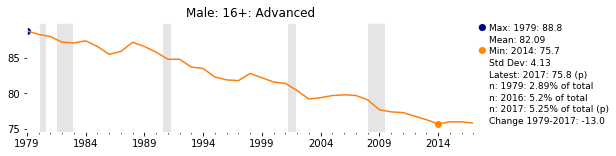

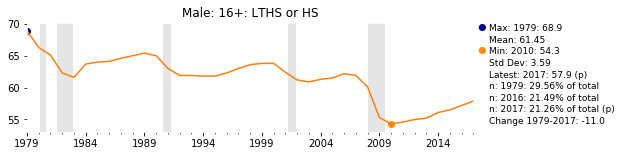

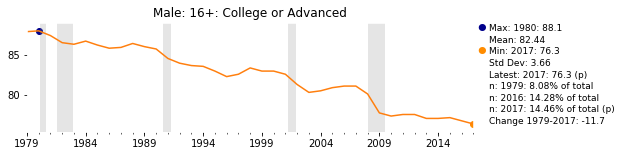

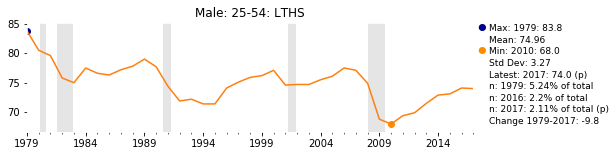

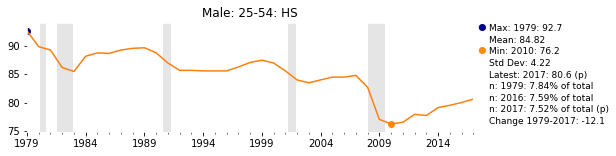

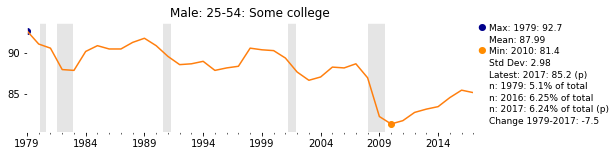

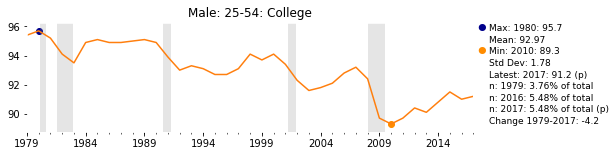

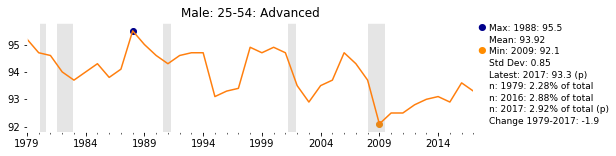

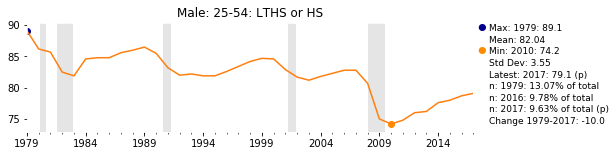

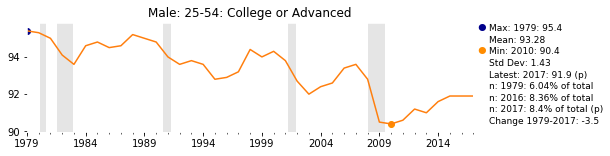

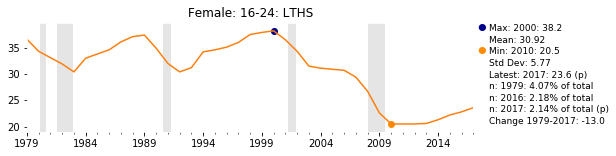

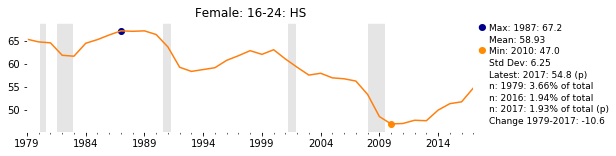

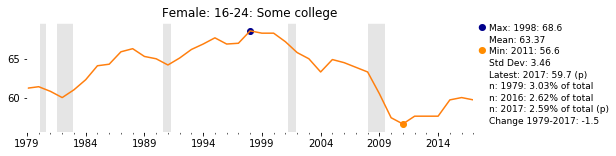

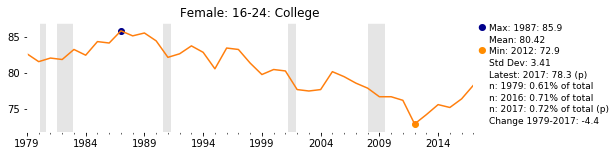

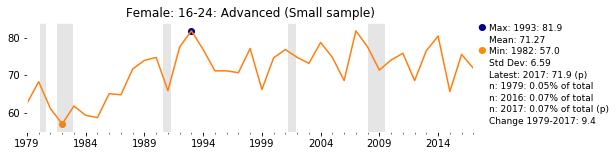

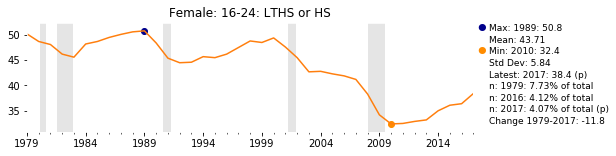

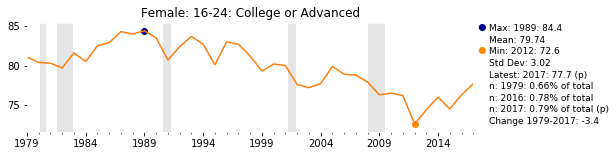

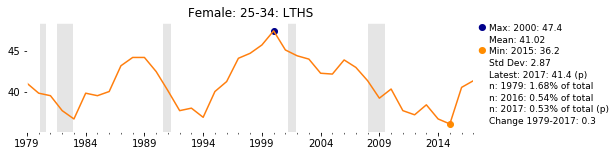

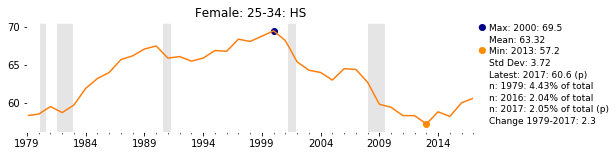

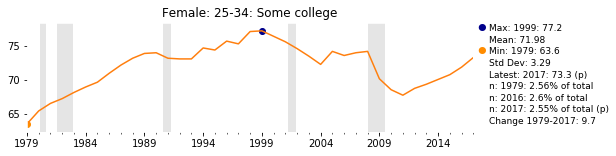

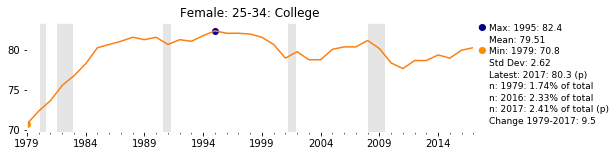

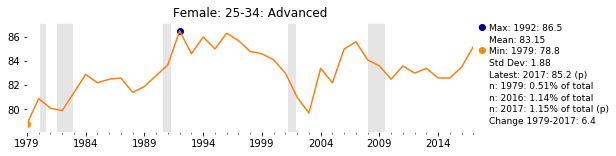

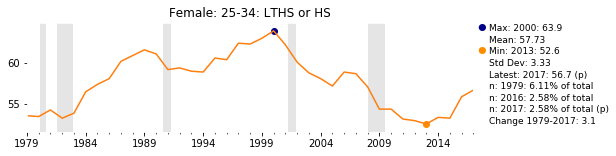

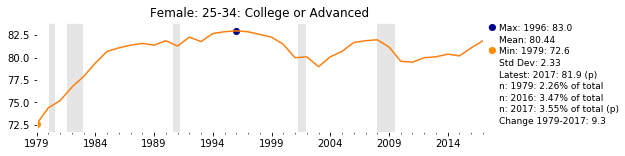

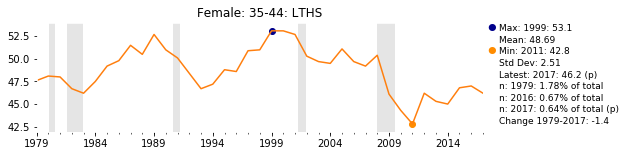

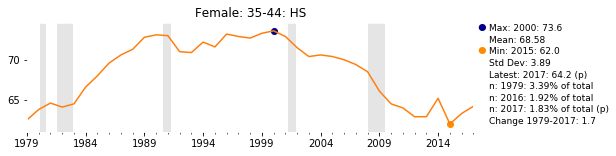

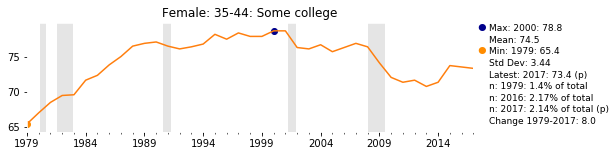

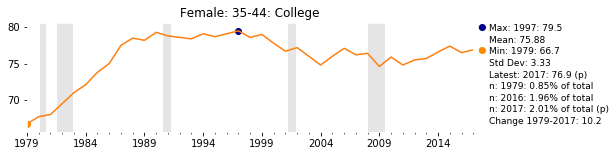

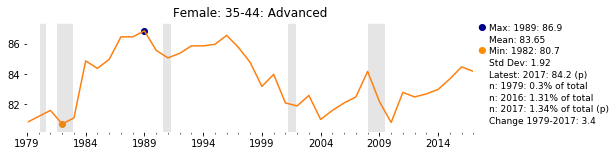

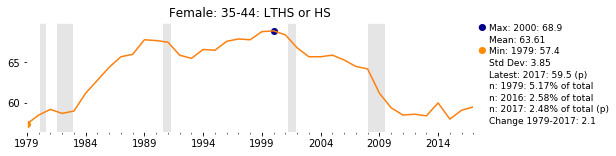

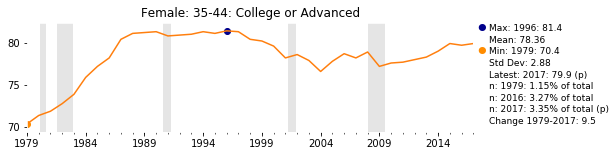

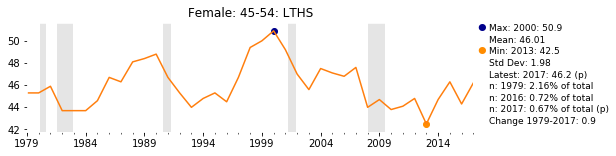

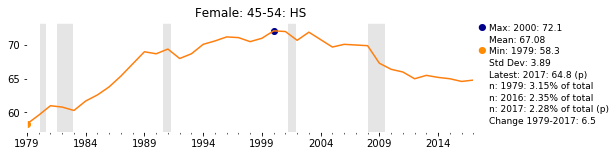

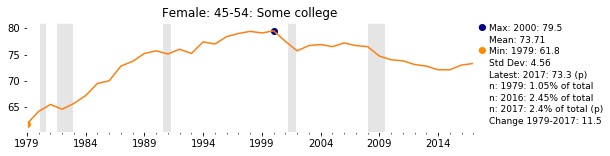

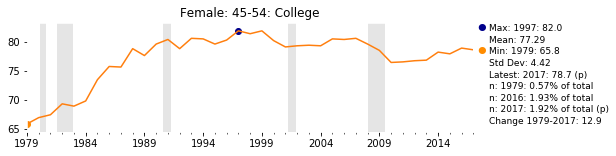

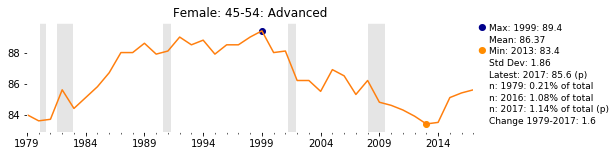

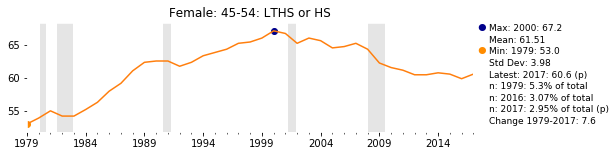

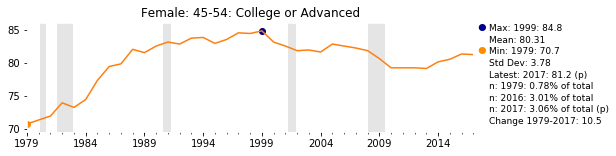

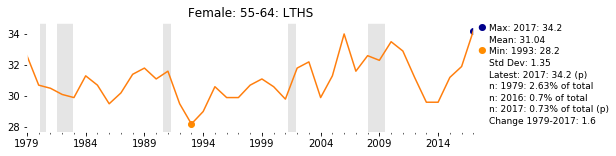

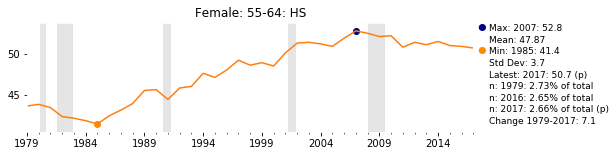

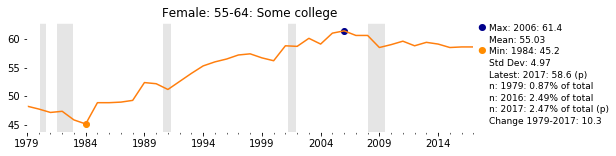

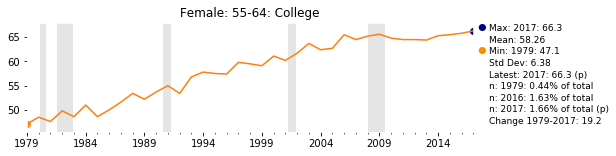

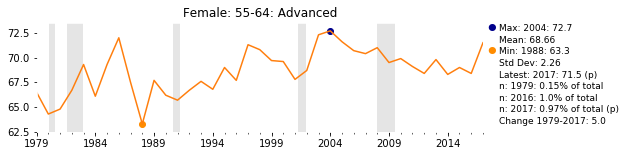

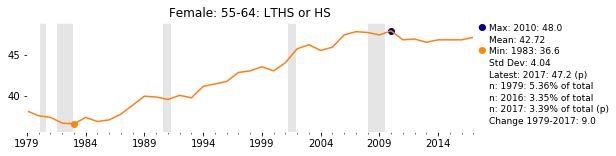

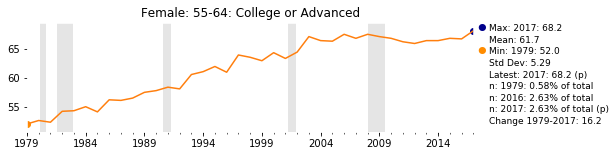

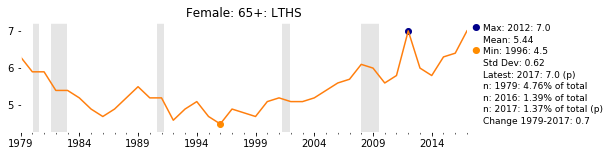

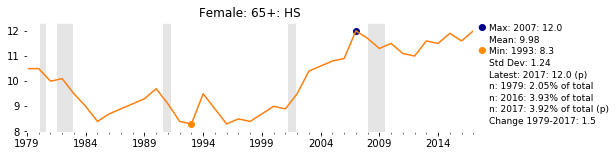

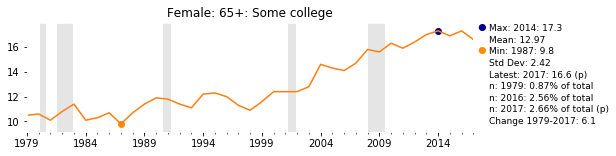

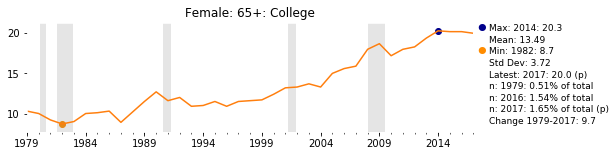

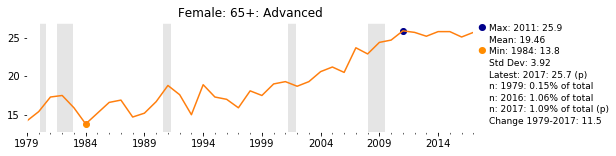

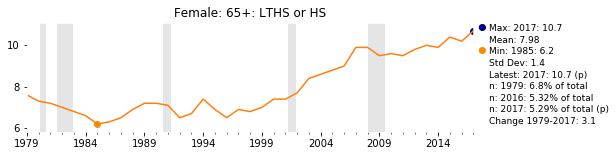

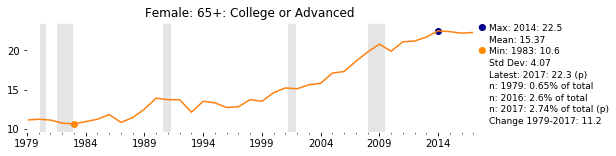

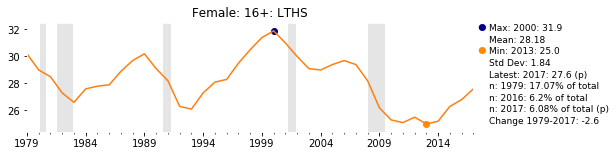

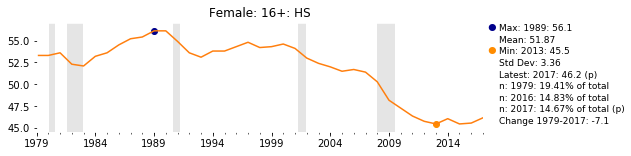

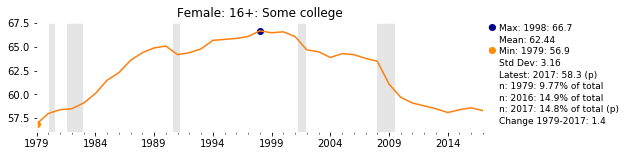

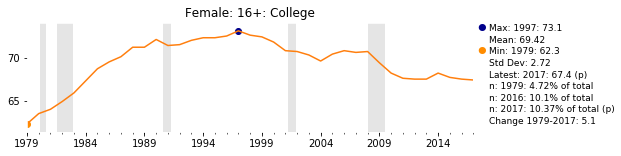

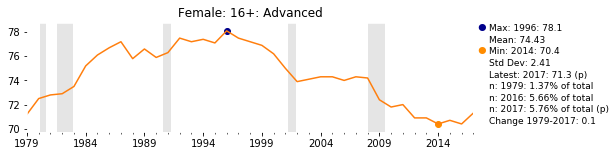

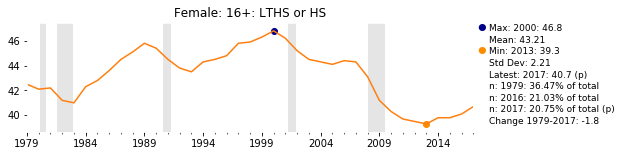

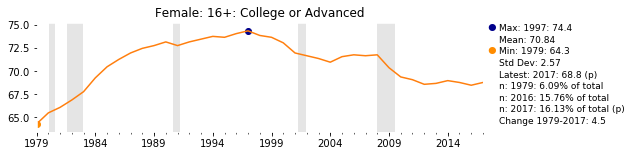

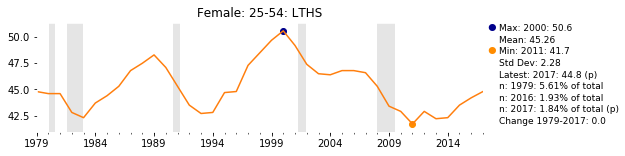

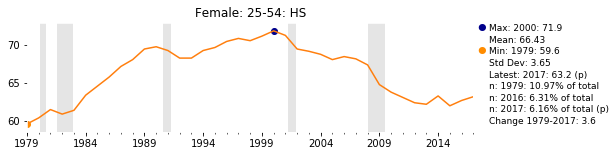

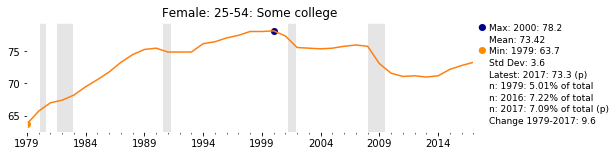

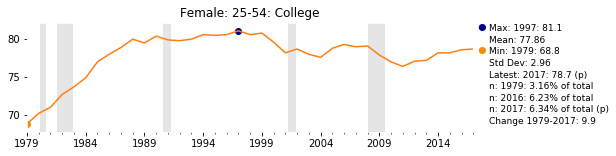

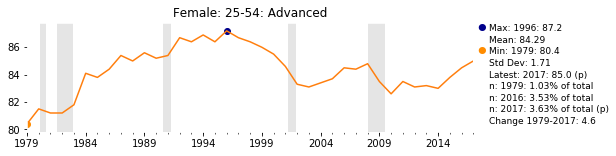

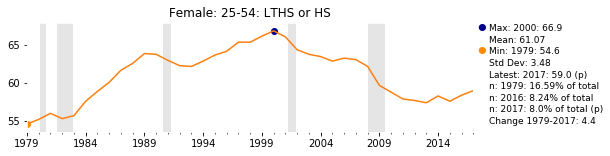

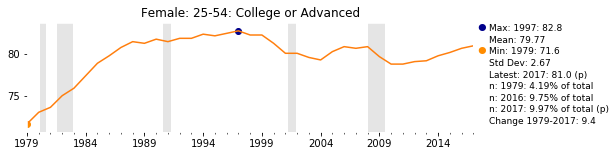

In [7]:
for name, values in data.iteritems():
    values = values.astype(float)
# Title
    nlast = int(last.loc[ldate, name])
    nNlast = round((nlast/Nlast) * 100, 2) 
    title = name
    if nNlast < 0.1:   # Note cases with small samples
        title = '{} (Small sample)'.format(name)
        
# Plot blank series          
    temp_df = pd.DataFrame([values.mean()] * ((len(years) -1) * 12 - 11))
    temp_df = temp_df.set_index(pd.date_range(start='1/1/{}'.format(sdate), 
                                              end='1/1/{}'.format(ldate), 
                                              freq='MS'))
    temp_df.plot(alpha=0, legend=False)
    sp = (values.max() - values.min()) / 8
    
# Shaded bars indicating recessions
    for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
        plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='gray', alpha=0.2)    
    
# Plot series
    values.plot(figsize=(8, 2), title=title)

# Summary stats added as text
    maxv = round(values.max(),2)
    maxy = values.idxmax().year
    plt.scatter(values.idxmax(), values.max(), color='darkblue')
    plt.text(565, maxv - (sp/2), u'\u2022', color='darkblue', fontsize=25)    
    plt.text(580, maxv, 'Max: {}: {}'.format(maxy, maxv), size=9)    
    
    minv = round(values.min(),2)
    miny = values.idxmin().year    
    plt.scatter(values.idxmin(), values.min(), color='darkorange')
    plt.text(565, maxv - (sp*2)- (sp/2), u'\u2022', color='darkorange', fontsize=25)    
    plt.text(580, maxv - (sp*2), 'Min: {}: {}'.format(miny, minv), size=9)    
    
    mean = round(values.mean(),2)
    plt.text(580, maxv - sp, 'Mean: {}'.format(mean), size=9)
    
    sd = round(values.std(),2)
    plt.text(580, maxv - (sp*3), 'Std Dev: {}'.format(sd), size=9)
    
    latest = round(values[-1],2)
    plt.text(580, maxv - (sp*4), 'Latest: {}: {} (p)'.format(ldatep, latest), size=9)
    
    nfirst = int(first.loc[sdate, name])
    nNfirst = round((nfirst/Nfirst) * 100, 2)
    plt.text(580, maxv - (sp*5), 'n: {}: {}% of total'.format(sdate, nNfirst), size=9)
    
    plt.text(580, maxv - (sp*6), 'n: {}: {}% of total'.format(ldate, nNlast), size=9)

    nlastp = int(lastp.loc[ldatep, name])
    nNlastp = round((float(nlastp)/float(Nlastp)) * 100, 2) 
    plt.text(580, maxv - (sp*7), 'n: {}: {}% of total (p)'.format(ldatep, nNlastp), size=9)    
    
    diff = round((values[-1] - values[0]),2)    
    plt.text(580, maxv - (sp*8), 'Change {}-{}: {}'.format(sdate, ldatep, diff), size=9)

In [8]:
values.astype(float).mean()

79.76666666666665